# <center>Capturing a Heartbeat from an Image</center>
<center>by Nigel Story</center>

## Contents

* [1. Introduction](#intro)
    * [1.1 About the Data](#about)
    * [1.2 Methods](#methods)
    * [1.3 Packages and Setup](#packages)
* [2. Image Processing](#processing)
* [3. Signal Extraction](#extraction)
* [4. DBSCAN Noise Removal](#dbscan)
* [5. Signal Scaling and Interpolation](#scaling)
* [6. Conclusion](#conclusion)

## Introduction

My life was changed. There I stood in a dark doctor's office with my wife, staring at a staticky screen and listen to a gentle "bubum... bubum..." through speakers mounted in the corners of the room. It was my son's heartbeat, and my first time hearing it. It was at our 8-week ultrasound, and he was about the size of a blueberry. And after this -- the most profound moment of my life so far -- they sent us home with a cheap role of grainy images to help us remember the moment, but I would never the sound of that hearbeat -- the first sound I heard from him -- again. But I could get close...

One of the images they sent home with us had the sound wave of his heartbeat printed on it with a scale for amplitude and "133bpm."

In this project, I'll be taking that image and reproducing the sound of my son's first heartbeat.

### About the Data

The data for this project is the image of the sound produced from the first ultrasound of my son's heartbeat. More specifically, a picture taken with an iPhone of the take-home printout provided by the ultrasound technician.

### Methods

My approach to extracting the sound from the image is fairly straight-forward: scan over the pixels of the image from left to right, recording the min and max row-indices of where the image changes from black to white and vice versa. Then I interpolate a soundwave between the mins and maxes with a cubic spline. I then sample the sound wave to the correct sampling rate of a WAV audio file, and normalize the wave so that it produces the desired 133 beats per minute.

Now that I've written it out, maybe the process isn't quite so straight-forward, so let's dive in.

### Packages and Setup

For processing the image, we'll rely on the OpenCV library, and for the matrix processing of the raw pixel values, numpy. We'll also use DBSCAN clustering as a way of identifying and removing outliers and noise that might translate from the image to the sound.

In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from scipy.io.wavfile import write
from scipy.interpolate import interp1d
from scipy import interpolate

## Image Processing

To prepare the image for signal extraction, we'll need to first rotate the image so that the x-axis of the sound wave is horizontal. Then we'll crop the image to contain two full periods of the heartbeat's signal and use binary thresholding to convert the image to black and white.

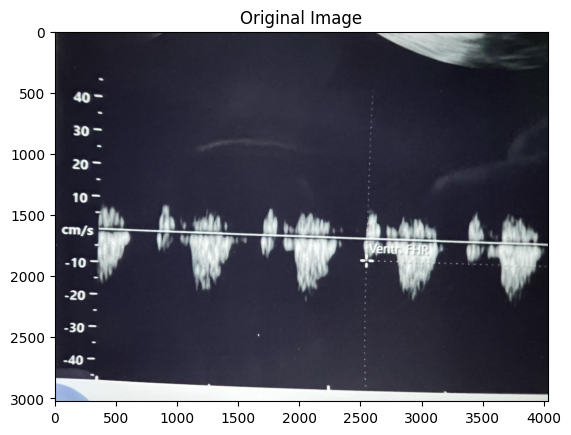

In [3]:
img = cv2.imread('./img/hb_2.jpg')
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.title("Original Image")
plt.imshow(img)
plt.show()

In [4]:
def rotate_image(image, angle):

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result


def crop_image(image):
    
    # return image[1500:2600, 420:2400]
    return image[1900:2700, 200:2000]

In [9]:
img = cv2.imread('./img/hb_2.jpg', cv2.IMREAD_GRAYSCALE)

ret, img = cv2.threshold(img, 75, 255, cv2.THRESH_BINARY)

img = rotate_image(img, 92)
img = crop_image(img)


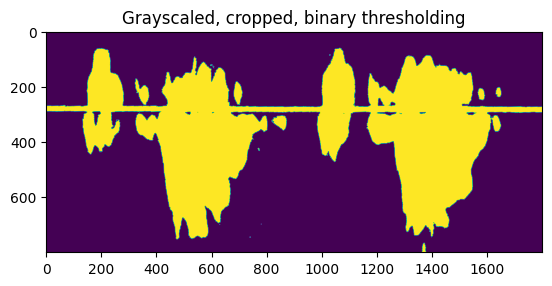

In [10]:
plt.title("Grayscaled, cropped, binary thresholding")
plt.imshow(img)
plt.show()

The image is almost ready for processing; however, the x-axis shows prominently as a thick horizontal line in this image. This will add background noise to the final sound output, so we'll try to remove it.

To do this, we'll make a simple detector for rows of pixels with high illumination. The detector will work by taking the average pixel value for each row of the image, and if the average excedes a threshold, then we'll set those pixel values to zero. To determine the threshold, let's take a look at a visualization of the average pixel values by row.

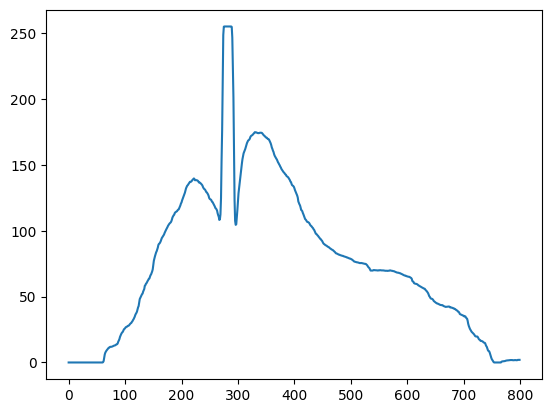

In [11]:
avg_vals = []
for row in img:
    avg_vals.append(row.mean())

plt.plot(avg_vals)
plt.show()


The spike in the middle represents the pixels of the x-axis, and while they average around 250 in brightness, the surrounding rows don't exceed 200, so we can set our threshold to 200 and filter out the x-axis from the image.

In [12]:
filtered_img = np.empty((0, img.shape[1]))
z = np.zeros((1, img.shape[1]))

for i in range(img.shape[0]):
    row = img[i]
    if row.mean() < 200:
        filtered_img = np.append(filtered_img, row.reshape(1,-1), axis=0)
    else:
        filtered_img = np.append(filtered_img, filtered_img[i-1].reshape(1,-1), axis=0)

filtered_img.shape

(800, 1800)

Let's take a look at how our filtering worked out.

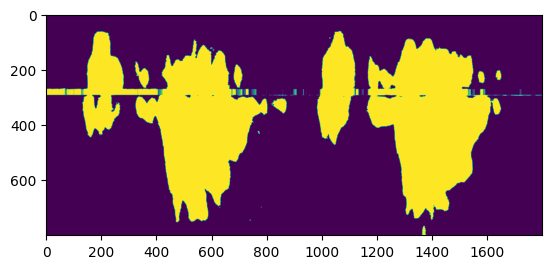

In [13]:
plt.imshow(filtered_img)

The filter worked fairly well, though there are still some areas around the x-axis with brighter pixel values, but our final signal should be much cleaner now.

## Signal Extraction

Now let's implement the pipeline for signal extraction. Like explained in the Methods section, our algorithm will scan the image from left to right, recording the min and max index values of pixel color changes, and interpolating zeros where there is no color change.

In [14]:
def extract_signal(img):
    """Estimate signal amplitude from image of sound wave.
    For each column of binarized image array, scan pixels
    and append indices to signal if current pixel
    and previous pixel have different values.

    Args:
        img (np.ndarray): numpy representation of image pixels

    Returns:
        (np.array): Indices of pixel value changes, estimating
            sound signal amplitude.
    """

    # init empty signal
    signal = np.empty((0, 2))

    for j in range(img.shape[1]): # cols
        for i in range(img.shape[0]): # rows
            prev = img[i-1, j]
            curr = img[i, j]

            if prev != curr: # if pixel value changes, append to output signal
                signal = np.append(signal, np.array([[j, img.shape[0] - i]]), axis=0)

    return signal


def interpolate_nan(signal):
    """Linearly interpolate nan and inf values in
    extracted signal.
    """

    inds = np.arange(signal.shape[0])
    good = np.where(np.isfinite(signal))
    f = interpolate.interp1d(inds[good], signal[good], bounds_error=False)
    
    out = np.where(np.isfinite(signal), signal, f(inds))

    return out


def extract_signal_alternate(img):
    """An alternate extraction method that ensures that
    sampled points alternate between crest and trough.

    Note:
        Not used. Signal is "too" sinusoidal, so it
        just produces beeps rather than the more staticky
        beats as they actually sounded.
    """

    def scan(col, direction):
        col_len = col.shape[0]
        if direction == 'down':
            i = 0
            while i < col_len:
                if col[i] != 0:
                    break
                i += 1

        else:
            i = col_len - 1
            while i >= 0:
                if col[i] != 0:
                    break
                i -= 1

        return i if i not in [-1, col_len] else np.nan


    # init empty signal
    signal = np.empty((0, 2))

    for j in range(img.shape[1]): # cols
        col = img[:, j]
        top = scan(col, 'down')
        bottom = scan(col, 'up')

        signal = np.append(signal, np.array([[j, img.shape[0] - top]]), axis=0)
        signal = np.append(signal, np.array([[j, img.shape[0] - bottom]]), axis=0)

    signal[:, 1] = interpolate_nan(signal[:, 1])

    return signal



In [15]:
signal = extract_signal(filtered_img)

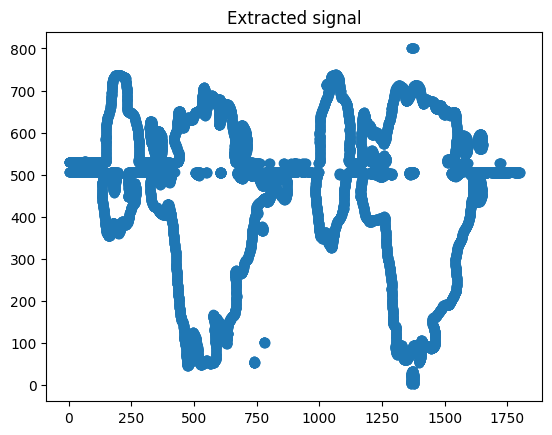

In [16]:
plt.title("Extracted signal")
plt.scatter(x=signal[:, 0], y=signal[:, 1])
plt.show()

Above, we can see the key points that will form our signal. However, there are some oulier points that will cause extra noise in the final signal, So our next steps will be removing the ouliers through density-based clustering analysis.

### DBSCAN Noise Removal

Clustering isn't typically used for outlier removal in signal data, but since this signal is produced from an image, it proves quite useful here. By using a density-based clustering algorithm, points that are relatively contiguous will be clustered together, and the outliers will form smaller, isolated clusters. So by implementing DBSCAN and filtering the data for the inliers cluster, we can clean up our final signal.

Since we want to avoid creating many small clusters in favor of creating one "main" cluster, the epsilon and minimum samples values for our DBSCAN implementation will be larger than usual.

In [17]:
# outlier removal with DBSCAN
dbs = DBSCAN(min_samples=10, eps=30)
dbs.fit(signal)

DBSCAN(eps=30, min_samples=10)

In [18]:
df = pd.DataFrame(signal, columns=['x', 'y'])
df['cluster'] = dbs.labels_

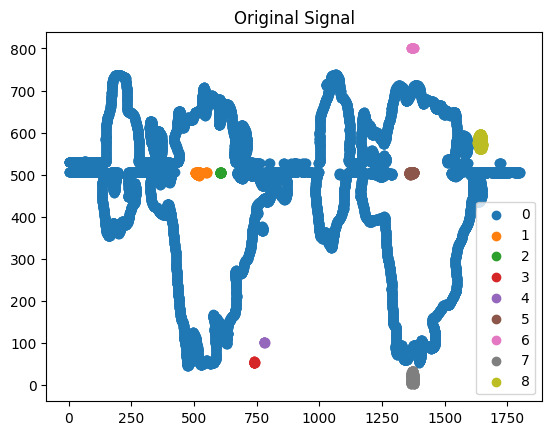

In [19]:
plt.title("Original Signal")
for c in df.cluster.unique():
    dummy = df.query(f"cluster == {c}")
    plt.scatter(x=dummy.x, y=dummy.y, label=c)
plt.legend()
plt.show()

Above, you can see that the inliers cluster is cluser "0." The outlier points are also nicely highlighted. Let's filter those out and review what our cleaned signal looks like.

In [20]:
filtered_df = df[df['cluster'].isin([0])].reset_index(drop=True)

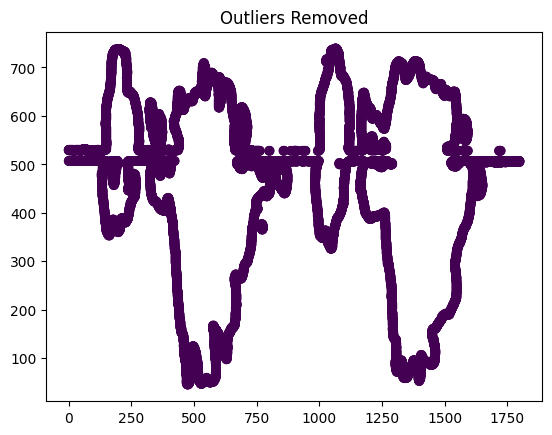

In [21]:
plt.title('Outliers Removed')
plt.scatter(x=filtered_df.x, y=filtered_df.y, c=filtered_df.cluster)
plt.show()

Alright, now we have the peaks and valley points of our heartbeat signal. In the next steps, we'll downsample this to a smaller number of data points, and then re-upsample the signal to make a waveform using cubic spline interpolation.

## Signal Scaling and Interpolation

Let's normalize the soon-to-be audio by scaling the data points between 0 and 1. Then we'll downsample by sampling every third data point. This will also ensure the alternation between peaks and valleys in our final sound wave.

In [22]:
filtered_df['amplitude'] = MinMaxScaler().fit_transform(filtered_df['y'].to_numpy().reshape(-1,1))
processed_signal = filtered_df[['amplitude']].to_numpy()
processed_signal.shape

(16624, 1)

In [23]:
# downsample
downsampled_signal = processed_signal[::3, :]
downsampled_signal.shape

(5542, 1)

Let's take a look at the downsampled data as a time series signal.

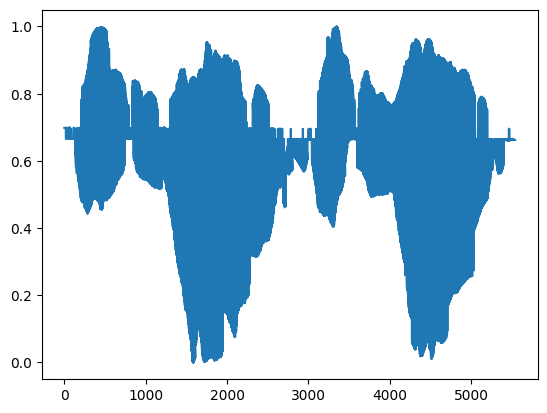

In [24]:
plt.plot(downsampled_signal)

If we listened to this signal as audio, we would immediately notice a few things. First, the sound would be high-pitched, and the beats would be much faster than 133 beats per minute, so we'll need to slow down the audio by reducing the frequency, or increasing the period, of the signal. Second, the sound would sound very "sharp" -- there would be excessing highend to the audio. We can mitigate this by smoothing out the signal using cubic spline interpolation to re-upsample the audio. Essentially turning sharp corners in the signal into smooth curves.

We'll start by calculating the amount by which we'll need to slow down and upsample the the signal based on the 40k herz playback rate of WAV files and our desired 133 beats per minute.

In [25]:
baby_bpm = 133
playback_rate = 48000
n_samples = downsampled_signal.shape[0]
beats_in_photo = 2

curr_elapsed_time_minutes = (n_samples / playback_rate) / 60
curr_bpm = 2 / curr_elapsed_time_minutes

slowdown_factor = curr_bpm / baby_bpm

print(f"Current BPM: {curr_bpm:0.2f}. Desired BPM: {baby_bpm}. Slowdown factor: {slowdown_factor:0.2f}.")

Current BPM: 1039.34. Desired BPM: 133. Slowdown factor: 7.81.


So we know now by how much we need to slow down our audio, but we'll first perform our interpolation and smoothing.

In [26]:
interp = interp1d(x=range(downsampled_signal.shape[0]), y=downsampled_signal, kind='cubic', axis=0)

And now to slow it down...

In [27]:
adj_signal = []

for i in np.arange(0, downsampled_signal.shape[0] - 1, 1/slowdown_factor):
    adj_signal.append(interp(i))

adj_signal = np.array(adj_signal)
adj_signal.shape

(43301, 1)

One of our final steps will be to center the start of the signal to zero, or silence. This will help mitigate and background hum.

In [28]:
center = adj_signal[:30].mean() # beginning of the signal should pretty much be silent, or 0
centered_signal = adj_signal - center

Let's take a look at the final signal!

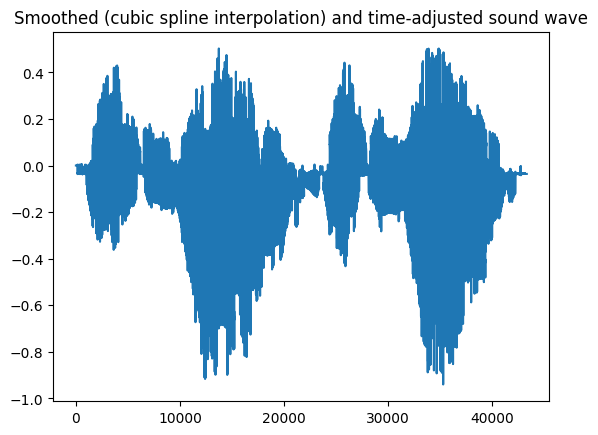

In [29]:
plt.title("Smoothed (cubic spline interpolation) and time-adjusted sound wave")
plt.plot(centered_signal)

Finally, let's write our signal out to a WAV audio file.

In [30]:
upsample = centered_signal
for i in range(4):
    upsample = np.append(upsample, upsample, axis=0)

upsample.shape

(692816, 1)

In [31]:
volume_reduction_factor = 0.1
bit_adj = 32767
scaled = np.int16(upsample*volume_reduction_factor/ np.max(np.abs(upsample)) * bit_adj)

In [32]:
ts = dt.datetime.now()
ts_str = ts.strftime("%Y%m%d%H%M%S")
file_name = f'./audio/heartbeat_{ts_str}.wav'
write(file_name, playback_rate, scaled)

## Conclusion

Listening to the sound of my son's first audible hearbeats is one of the most important moments of my life, and with this project I was able to capture a bit of that magic.

While the audio produced isn't exactly the same as the sound we heard in the ultrasound room, but it's very close! To be honest, I didn't expect this experiment to work at all -- it seemed like a pretty silly notion. The fact that it actually worked and that I can listen to the audio and remember the feeling of that moment is amazing, and it's why I love working with data. It can do so much more than forecast sales or generate text; it can change people's lives for the better.

### Thanks for Reading!